# Binary Classification

So far, you've only created regression models. That is, you created models that produced floating-point predictions, such as, "houses in this neighborhood costs N thousand dollars." In this Colab, you'll create and evaluate a binary [classification model](https://developers.google.com/machine-learning/glossary/#classification_model).  That is, you'll create a model that answers a binary question. In this exercise, the binary question will be, "Are houses in this neighborhood above a certain price?"

## Regularization
We don't want our model to overfit, which is as we go through more and more training iterations, the training loss keeps going down but the validation loss (and eventually the test loss) goes up.

There's a lot of regularization strategies. One of them is `early stopping`, meaning that we stop training before the model converges on the training data. Other methods usually try to penalize the model complexity, where instead of simply aiming to minimize loss (empirical risk minimization):

$$
\min(\text{Loss}(\text{Data} \mid \text{Model}))
$$

we now minimize loss+complexity, which is called `structural risk minimization`.

$$
\min\Big(\text{Loss}(\text{Data} \mid \text{Model}) + \lambda \text{ complexity(Model)} \Big)
$$

where $\lambda$ controls the strength of the regularization effect.

The two common ways to think of model complexity are:

- `L2 regularization`: model complexity as a function of the weights of all the features in the model.
- `L1 regularization`: model complexity as a function of the total number of features with nonzero weights. This is introduced in a later chapter.

$L_2$ regularization defines the regularization term as the sum of squares of all the feature weights:

$$
L_2 \text{ regularization term} = \|\boldsymbol{w}\|_2^2 = w_1^2 + w_2^2 + \cdots + w_n^2
$$

$L_2$ regularization encourages weight values toward 0 (but not exactly 0), and the mean of the weights toward 0 with a normal distribution.

## Logistic regression

Many problems require a probability estimate $p \in [0, 1]$ as output. `Logistic regression` is highly efficient for calculating probabilities, and in many cases we can map the output into a binary classification problem by setting a threshold.

If $z$ represents the output of the linear layer, then sigmoid(z) will yield a probaility between 0 and 1:

$$
y^\prime = \frac{1}{1 + e^{-z}}
$$

where $y^\prime$ is the output of the logistic regression model, and

$$
z = b + w_1 x_1 + w_2 x_2 + \cdots + w_N x_N
$$

The loss function, instead of the squared loss in linear regression, is the `log loss` defined as:

$$
\sum_{(x, y) \in D} -y\log(y^\prime) - (1-y) \log(1-y^\prime)
$$

where $(x, y) \in D$ is the dataset containing labeled examples, $y$ is the true label and $y^\prime$ is the predicted value between 0 and 1 given the set of features $x$.

Regularization is extremely important in logistic regression modeling. Without regularization, the asymptotic nature of logistic regression would keep driving loss towards 0 in high dimensions, i.e. completely overfit.

## Metrics

### Accuracy, precision and recall
Logistic regression returns a probability. To convert it to a binary value, a `classification threshold` must be defined. A value above the threshold indicates one label and a value below it indicates the other.

See the [confusion matrix](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative) to understand true/false positive/negatives. The following metrics are defined using these four values.

$$
\text{Accuracy} = \frac{\text{# of correct predictions}}{\text{Total # of predictions}}
$$

which in binary classification equals

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

`Accuarcy` measures the percentages of things the model got right. It breaks down when we have class imbalance. `Precision` and `recall` are defined as:

$$
\begin{gathered}
    \text{Precision} = \frac{TP}{TP + FP} \\
    \text{Recall} = \frac{TP}{TP + FN}
\end{gathered}
$$

To fully evaluate the effectiveness of a model, you must examine **both precision and recall**. When the classification threshold is raised, precision generally increases because false positives are reduced. Various metrics have been developed that rely on both precision and recall, such as the [F1 score](https://en.wikipedia.org/wiki/F1_score).

### ROC curve and AOC
An ROC curve (receiver operating characteristic curve) shows the performance of a classification model at all classification thresholds.

The `true positive rate` (TPR) isa synonym for recall:

$$
TPR = \frac{TP}{TP + FN}
$$

The `false positive rate` (FPR) is

$$
FPR = \frac{FP}{FP + TN}
$$

An ROC curve plots TPR against FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives.

`AUC` stands for "area under the ROC curve". AUC provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is as the probability that the model [ranks a random positive example more highly than a random negative example](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc#AUC).

### Prediction bias

Logistic regression predictions should be unbiased, that is the average of predictions should be approximately equal to the average of observations. The difference between the two averages is the `prediction bias`.

Since all labels are either 0 or 1, when examining prediction bias we need to use a "bucket" of samples. Buckets can be formed by linearly breaking up the target predictions, or by using quantiles. `Calibration plots` are often used to analyze the prediction bias.

## The Dataset
  
Like the previous Colabs, this Colab uses the [California Housing Dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description).

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score

import seaborn as sns
from matplotlib import pyplot as plt

from tqdm import tqdm
from IPython.display import clear_output, display

sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the training set

Unlike some of the previous Colabs, the preceding code cell did not scale the label (`median_house_value`).  The following section ("Normalize values") provides an alternative approach.

## Normalize values

When creating a model with multiple features, the values of each feature should cover roughly the same range.  For example, if one feature's range spans 500 to 100,000 and another feature's range spans 2 to 12, then the model will be difficult or impossible to train. Therefore, you should 
[normalize](https://developers.google.com/machine-learning/glossary/#normalization) features in a multi-feature model. 

The following code cell normalizes datasets by converting each raw value (including the label) to its Z-score. A **Z-score** is the number of standard deviations from the mean for a particular raw value. For example, consider a feature having the following characteristics:

  * The mean is 60.
  * The standard deviation is 10.

The raw value 75 would have a Z-score of +1.5:

```
  Z-score = (75 - 60) / 10 = +1.5
```

The raw value 38 would have a Z-score of -2.2:

```
  Z-score = (38 - 60) / 10 = -2.2
```

In [3]:
# Calculate the Z-scores of each column in the training set and
# write those Z-scores into a new pandas DataFrame named train_df_norm.
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

# Calculate the Z-scores of each column in the test set and
# write those Z-scores into a new pandas DataFrame named test_df_norm.
test_df_mean = test_df.mean()
test_df_std  = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

# Examine some of the values of the normalized training set. Notice that most 
# Z-scores fall between -2 and +2.
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
10399,-0.328098,1.134483,-1.159087,0.531818,0.354898,-0.261858,-0.062993,-0.610421,-0.606127
14523,-1.290612,0.989443,1.621574,-0.604907,-0.622565,-0.579843,-0.570117,-0.299283,-0.769943
12552,-1.041256,0.488820,-0.046823,-0.329212,0.039358,0.250403,0.087845,-1.019349,-0.725109
9898,-0.078742,-0.568569,0.509310,-0.813169,-0.935733,-0.937031,-0.902999,0.229448,1.159637
6151,0.664338,-0.811862,0.588757,-0.020947,-0.060287,0.385438,0.033231,-0.375691,-0.772530


## Task 1: Create a binary label

In classification problems, the label for every example must be either 0 or 1. Unfortunately, the natural label in the California Housing Dataset, `median_house_value`, contains floating-point values like 80,100 or 85,700 rather than 0s and 1s, while the normalized version of `median_house_values` contains floating-point values primarily between -3 and +3.

Your task is to create a new column named `median_house_value_is_high` in both the training set and the test set . If the `median_house_value` is higher than a certain arbitrary value (defined by `threshold`), then set `median_house_value_is_high` to 1. Otherwise, set `median_house_value_is_high` to 0. 

**Hint:** The cells in the `median_house_value_is_high` column must each hold `1` and `0`, not `True` and `False`. To convert `True` and `False` to  `1` and `0`, call the pandas DataFrame function `astype(float)`. 

In [4]:
# The following possible solution uses a Z-score
# of +1.0 as the threshold, meaning that no more
# than 16% of the values in median_house_value_is_high
# will be labeled 1.

threshold_in_Z = 1.0 
train_df_norm["median_house_value_is_high"] = (train_df_norm["median_house_value"] > threshold_in_Z).astype(float)
test_df_norm["median_house_value_is_high"] = (test_df_norm["median_house_value"] > threshold_in_Z).astype(float) 

train_df_norm["median_house_value_is_high"]

10399    0.0
14523    0.0
12552    0.0
9898     1.0
6151     0.0
        ... 
10985    0.0
11227    0.0
13444    0.0
968      0.0
4042     0.0
Name: median_house_value_is_high, Length: 17000, dtype: float64

## Define dataset and model

In [5]:
# Map features and labels into a tensor dataset
class HousingDataset(Dataset):
    def __init__(self, X, y):
        self.x = torch.tensor(X.to_numpy().reshape(-1, X.shape[1]), dtype=torch.float)
        self.y = torch.tensor(y.to_numpy().reshape(-1, 1), dtype=torch.float)
    
    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])
    
    def __len__(self):
        return len(self.y)
    

dat = HousingDataset(train_df_norm[["median_income", "total_rooms"]], train_df_norm["median_house_value_is_high"])
test_dat = HousingDataset(test_df_norm[["median_income", "total_rooms"]], test_df_norm["median_house_value_is_high"])

## Define functions that build and train a model

The following code cell defines two functions:

  * `create_model(my_learning_rate, feature_layer, my_metrics)`, which defines the model's
    topography.
  * `train_model(model, dataset, epochs, label_name, batch_size, shuffle)`, uses input features and labels to train the model.

Prior exercises used [ReLU](https://developers.google.com/machine-learning/glossary#ReLU) as the [activation function](https://developers.google.com/machine-learning/glossary#activation_function). By contrast, this exercise uses [sigmoid](https://developers.google.com/machine-learning/glossary#sigmoid_function) as the activation function. 

In [6]:
# Define the model
class LogisticRegressionModel(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.linear = nn.Linear(num_features, 1)
        
    def forward(self, x):
        y_hat = self.linear(x)
        return y_hat

In [7]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.35

torch.manual_seed(42)
my_model = LogisticRegressionModel(2).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.RMSprop(my_model.parameters(), lr = learning_rate)

train_loader = DataLoader(dataset=dat, batch_size=batch_size, shuffle=True)

losses = []
accuracy = []
precision = []
recall = []
roc_auc = []

for epoch in range(epochs):
    display(f"Epoch: {epoch + 1}")

    epoch_losses = []
    epoch_accuracy = []
    for x_batch, y_batch in tqdm(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        my_model.train()
        y_hat = my_model(x_batch)
        loss = criterion(y_hat, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
        
        # Calculate and track accuracy
        with torch.no_grad():
            y_true, y_pred = y_batch.cpu().numpy(), y_hat.cpu().numpy()
            y_pred = np.where(y_pred > classification_threshold, 1.0, 0.0)
            epoch_accuracy.append(accuracy_score(y_true, y_pred))

    losses.append(np.mean(epoch_losses))
    accuracy.append(np.mean(epoch_accuracy))
    clear_output(wait=True)
    display(f"Loss (BCE): {losses[-1] :.4f} | Accuracy: {accuracy[-1]:.4f}")

test_loader = DataLoader(dataset=test_dat, batch_size=batch_size)
test_losses = []
test_accuracy = []
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        y_hat = my_model(x_test)
        loss = criterion(y_hat, y_test)
        test_losses.append(loss.item())
        
        y_true, y_pred = y_test.cpu().numpy(), y_hat.cpu().numpy()
        y_pred = np.where(y_pred > classification_threshold, 1.0, 0.0)
        test_accuracy.append(accuracy_score(y_true, y_pred))
    
print(f"Test set loss: {np.mean(test_losses):.4f} | Accuracy: {np.mean(test_accuracy):.4f}")
print(my_model.state_dict())

'Loss (BCE): 0.3126 | Accuracy: 0.8823'

Test set loss: 0.3130 | Accuracy: 0.8853
OrderedDict([('linear.weight', tensor([[ 1.5828, -0.0851]], device='cuda:0')), ('linear.bias', tensor([-2.1387], device='cuda:0'))])


Text(0.5, 1.0, 'Accuracy')

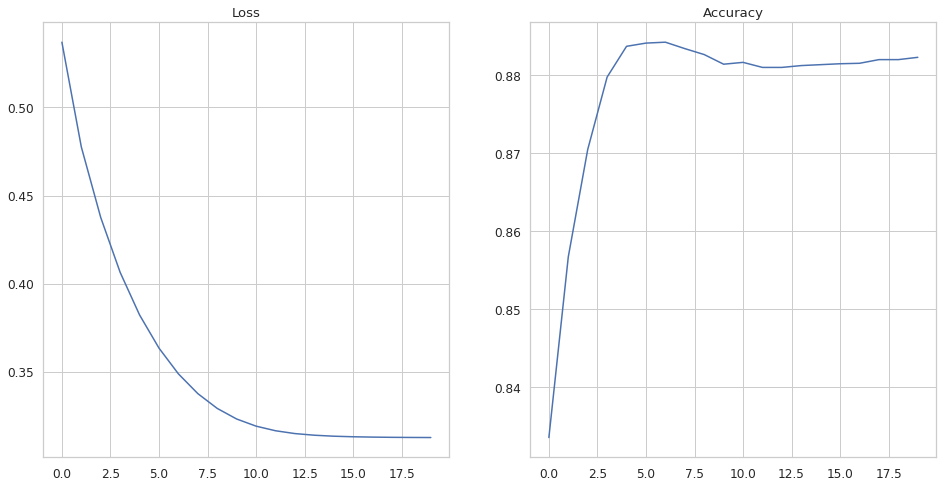

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.lineplot(x=np.arange(0, epochs), y=losses, ax=ax[0])
sns.lineplot(x=np.arange(0, epochs), y=accuracy, ax=ax[1])

ax[0].set_title("Loss")
ax[1].set_title("Accuracy")

Accuracy should gradually improve during training (until it can 
improve no more).